# KCUSUM
### Experimental Branch

#### Module Imports

In [1]:
import numpy as np
import sklearn
from sklearn import metrics
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sb
sb.set()
import os
import sys
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.utils.extmath import svd_flip, randomized_svd
import scipy.io
from scipy.sparse.linalg import svds
import scipy.ndimage as ndi
from heapq import heappush, heappop
from pprint import pprint
from random import uniform
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

#### Generate Reference Data

In [2]:
sample_x_0 = np.random.normal(1,1,size=400)
sample_x_1 = np.random.normal(1,4,size=200)


sample_y_0 = np.random.normal(1,1,size=200)
sample_y_1 = np.random.normal(1,4,size=200)


sample_z_0 = np.random.normal(1,1,size=200)
sample_z_1 = np.random.normal(1,4,size=200)

In [3]:
ref_sample = sample_x_0
test_sample = np.append(sample_y_0,sample_y_1)
#test_sample

#### Define Gaussian Kernel/MMD

In [4]:
def gk(x,y):
  return np.exp(-((x-y)**2/2.0))


def mmd(x_n_1, x_n, y_n_1, y_n):
    xx = gk(x_n_1, x_n)
    yy = gk(y_n_1, y_n)
    xy = gk(x_n_1, y_n)
    yx = gk(x_n, y_n_1)
    return xx + yy - xy - yx  

#### Import SVD_Wrapper

In [5]:
def svd_wrapper(Y, k, method='svds'):
    if method is 'svds':
        Ut, St, Vt = svds(Y, k)
        idx = np.argsort(St)[::-1]        
        St = St[idx] # have issue with sorting zero singular values
        Ut, Vt = svd_flip(Ut[:, idx], Vt[idx])
    elif method is 'random':
        Ut, St, Vt = randomized_svd(Y, k)
    else:
        Ut, St, Vt = np.linalg.svd(Y, full_matrices=False)
        # now truncate it to k
        Ut = Ut[:, :k]
        St = np.diag(St[:k])
        Vt = Vt[:k, :]
        
    return Ut, St, Vt

#### Sample Data Preprocessing

In [6]:
mat= scipy.io.loadmat('collision_0-256.mat')
coll = mat['trace']
shapetest = coll
shapetest

array([[[-38.588509,  31.486088, 124.245422],
        [-38.904312,  32.39389 , 124.620537],
        [-38.182739,  31.671265, 123.36467 ],
        ...,
        [ 11.096417,  24.958757, 137.562073],
        [ 12.030968,  24.631891, 137.536453],
        [ 10.993629,  24.990107, 138.5569  ]],

       [[-38.581264,  31.483677, 124.246391],
        [-38.900215,  32.395161, 124.610184],
        [-38.200001,  31.667702, 123.353279],
        ...,
        [ 11.097125,  24.960527, 137.564529],
        [ 12.027571,  24.618774, 137.568039],
        [ 10.978704,  25.003279, 138.555832]],

       [[-38.575676,  31.481556, 124.247566],
        [-38.890774,  32.389526, 124.600639],
        [-38.210121,  31.663651, 123.336502],
        ...,
        [ 11.097929,  24.96217 , 137.56723 ],
        [ 12.024109,  24.605516, 137.596664],
        [ 10.961408,  25.017021, 138.551788]],

       ...,

       [[-37.960289,  31.775253, 125.563232],
        [-38.260132,  32.152901, 126.456978],
        [-37.599461,  

In [7]:
(x2,y2,z2) = coll.shape
coll.shape
t2 = coll.reshape((x2, y2*z2),order='C')
t2

array([[-38.588509,  31.486088, 124.245422, ...,  10.993629,  24.990107,
        138.5569  ],
       [-38.581264,  31.483677, 124.246391, ...,  10.978704,  25.003279,
        138.555832],
       [-38.575676,  31.481556, 124.247566, ...,  10.961408,  25.017021,
        138.551788],
       ...,
       [-37.960289,  31.775253, 125.563232, ...,  10.153194,  25.984735,
        137.847198],
       [-37.956963,  31.771517, 125.57341 , ...,  10.15202 ,  25.991091,
        137.79834 ],
       [-37.954533,  31.768862, 125.583534, ...,  10.156665,  25.994097,
        137.743195]])

#### Verify Reference/Sample Array Shape

In [8]:
t2.shape

(255, 27099)

#### Define KCUSUM

In [9]:
T_kcusum = 0

def KCUSUM(x_1, x_2, yz_1, yz_2, h,delta):
  global T_kcusum  
  Z_n = 0
  h >= 0
  delta >= 0
  n = 400

  for i in range(2,n):


    if i%2 == 0:
      av_n = mmd(x_1,x_2,yz_1,yz_2).mean()
      v_n = av_n/3
    else:
      v_n = 0
      
    Z_n += v_n

    if Z_n < 0:
      Z_n = 0

    if Z_n > h:
      T_kcusum = i
      break
  return T_kcusum

#### Apply SVD to Reference/Sample

In [10]:
Utl, Stl, VTtl = svd_wrapper(t2, 2, method='random')

In [11]:
svd_ref = Utl
#svd_ref

In [12]:
svd_test = svd_ref
#svd_ref

In [13]:
cp_inject_1 = np.random.normal(1,.5,size=255)
cp_inject_2 = np.random.normal(1,.5,size=255)

baseline = np.zeros(99)

baseline2 = np.append(baseline,cp_inject_1[0:49])
baseline3 = np.append(baseline2,np.zeros(107))

cbase2 = np.append(baseline,cp_inject_2[0:49])
cbase3 = np.append(cbase2,np.zeros(107))

In [14]:
x_data = svd_test[:,1:2]
#x_data

In [15]:
y_data = svd_test[:,0:1]
#y_data

In [16]:
new_lst = [[i] for i in baseline3]
#new_lst

In [17]:
newnew_lst = [[i] for i in cbase3]
#newnew_lst

In [18]:
x_inj = np.sum([x_data, new_lst], axis=0)
#x_inj

In [19]:
y_inj = np.sum([y_data, newnew_lst], axis=0)
#y_inj

In [20]:
artif_cp = np.concatenate((y_inj, x_inj), axis=1)
svd_inj_cp = artif_cp
#svd_inj_cp

In [21]:
svd_ref

array([[ 0.06262202, -0.07996474],
       [ 0.062622  , -0.07999833],
       [ 0.06262199, -0.0800133 ],
       [ 0.06262198, -0.08000829],
       [ 0.06262198, -0.07998522],
       [ 0.06262199, -0.07994068],
       [ 0.062622  , -0.07987249],
       [ 0.06262202, -0.07978315],
       [ 0.06262204, -0.07967896],
       [ 0.06262207, -0.07956161],
       [ 0.0626221 , -0.07943522],
       [ 0.06262213, -0.07929855],
       [ 0.06262215, -0.07915119],
       [ 0.06262218, -0.07899272],
       [ 0.06262219, -0.07882493],
       [ 0.06262219, -0.07865008],
       [ 0.06262218, -0.07846716],
       [ 0.06262217, -0.07828069],
       [ 0.06262215, -0.07809331],
       [ 0.06262212, -0.07790836],
       [ 0.0626221 , -0.07772388],
       [ 0.06262208, -0.07753147],
       [ 0.06262206, -0.07732281],
       [ 0.06262204, -0.07710111],
       [ 0.06262203, -0.07686733],
       [ 0.06262202, -0.07661735],
       [ 0.06262201, -0.07635057],
       [ 0.062622  , -0.07606798],
       [ 0.062622  ,

#### KCUSUM onSVD Data

In [23]:
KCUSUM(svd_ref[:,0],svd_inj_cp[:,0],svd_ref[:,1],svd_inj_cp[:,1],.06,.005)

54

#### -Artificial CP added at t = 49. Average delay around 5-10 t

In [24]:
mmd(svd_ref[:,0],svd_inj_cp[:,0],svd_ref[:,1],svd_inj_cp[:,1]).mean()

0.006703513347790985

### Conisderations

#### -Apply artifical CP to raw vs. reduced data

#### -Gradual vs. Abrupt CP: Gaussian noise/linear increase Gauss

#### -Best way to visualize: Page 7/10 KCUSUM paper?

### Test Ground: ResSample/CP Visual-Needs adjustment

In [78]:
class MDTrSampler:
    def __init__(self, n_atoms, n_dim = 2, conv_size = 50, n_samples=1000, batch_size=100, manifold_size=64):
        self.n_dim = n_dim
        self.conv_size = conv_size
        self.n_atoms = n_atoms
        self.batch_size = batch_size
        self.l = manifold_size
        self.n_samples = n_samples
        self.bq = np.zeros((batch_size,n_atoms,3)) # batch queue
        self.total_samples = 0
        self.bq_index = 0
        self.Btp = np.zeros((n_atoms*3,self.l))
        self.strm_smplr = WeightedReservoirSampler(n_samples)
        self.last_Vt = None
    
    def traj_char(self, c, s):
        x = c.shape[0]
        # scaled data <-- not so much meaningful as we're doing l2 normalization later
        ps = np.mat(c[:,:self.n_dim]) * np.mat(np.diag(s[:self.n_dim]))
        # gradient or changes of each data point
        psd = ps[0:(x-1),:self.n_dim] - ps[1:x, :self.n_dim];
        
        # convoluted gradient --> smoothed gradient
        psdm = ndi.convolve(psd, np.ones((self.conv_size,2))/self.conv_size*2);
        # L2 normalized smoothed gradients --> now we focus on the angle of gradient only as atoms may move different speed 
        npsdm = np.divide(psdm, np.mat(np.sum(np.abs(psdm)**2,axis=-1)**(1./2)).T  * np.mat(np.ones((1,n_dim))))
        # Angle smoothing with the assumption that the overall angle can not be radically changed
        nmpsdm = ndi.convolve(npsdm, np.ones((self.conv_size,2))/self.conv_size*2);
        # Smoothed angle changes (accelerations)
        psdd = nmpsdm[0:(x-2)] - nmpsdm[1:(x-1)]
        # results for gradient of changes
        psdu = np.sum(abs(psd),axis=1)
        # results of smoothed normalized acceleration
        psddu = np.sum(abs(psdd),axis=1)
        prob_dist = (abs(psddu) / np.sum(psddu))
        return nmpsdm, psddu, prob_dist
    
    def strmML(self, t2):
        n_t = t2.shape[1]
        Ct = np.concatenate( (self.Btp, t2), axis = 1)
        Ct = Ct[:, ~(Ct==0).all(0)]

        Ut, St, Vt = svd_wrapper(Ct, self.l) #SVD_l(matrix)
        Ut_l = Ut[:, :self.l]
        St_l = St[:self.l] - St[self.l-1] # to be adaptive, added singular substraction
        Vt_l = Vt[:self.l, -n_t:]
        self.Btp= np.dot(Ut_l, np.diag(St_l))

        return Ut_l, St_l, Vt_l
    
    def batch_sampling(self, trace):
        (x,y,z) = trace.shape
        self.sampling_rate = float(self.n_samples) / float(x)
        t2 = trace.reshape((x, y*z),order='C')
        c,s,v = svd_wrapper(t2, 2, method='random')
        nmpsdm, psddu, prob_dist = self.traj_char(c,s) 
        total = 10**-10 + prob_dist[0]
        sampling_entries = int(x * self.sampling_rate)
        target = np.zeros((sampling_entries, y, z))
        time_stamps = np.zeros(sampling_entries)
        #output initialization: the first one should be added always
        target[0,:,:] = trace[0,:,:]
        time_stamps[0] = 0;
        t_idx = 1;
        for i in range(2,x):
            total = total + prob_dist[i-2];
            if(total > 1 / float(sampling_entries - 1)):
                target[t_idx,:,:] = trace[i,:,:]
                time_stamps[t_idx] = i
                total = total - 1 / float(sampling_entries-1);
                t_idx = t_idx + 1;
        return target, time_stamps
    
    
    def adaptive_sampling_update(self):
        t2 = self.bq[0:self.bq_index,:,:].reshape((self.bq_index, self.n_atoms*z),order='C').T
        Ut, s, VTt = self.strmML(t2)
        if self.last_Vt is None: # for the first time
            c = VTt.T
            self.strm_smplr.add(10**10,[0, self.bq[0,:,:]])
            nmpsdm, psddu, prob_dist = self.traj_char(c, s)
            sidx = self.total_samples - self.bq_index
            for i in range(2,self.bq_index):
                self.strm_smplr.add(psddu[i-2], [sidx+i, self.bq[i,:,:]])
        else:
            c =  np.concatenate( (self.last_Vt, VTt.T), axis = 0)
            nmpsdm, psddu, prob_dist = self.traj_char(c, s)
            sidx = self.total_samples - self.bq_index
            for i in range(0,self.bq_index):
                self.strm_smplr.add(psddu[i], [sidx+i, self.bq[i,:,:]])
                
        self.last_Vt = VTt.T[-2:,:] # for last two to start compare against
        
        

    def adaptive_sampling_step(self, dataframe_t):
        self.total_samples = self.total_samples + 1
        self.bq[self.bq_index] = dataframe_t
        self.bq_index = self.bq_index+1
        if self.bq_index == (self.batch_size):
            self.adaptive_sampling_update()
            self.bq_index = 0
        

In [36]:
cps=[]
hs=[]

def cp_vs_h(sample_x_ref,sample_y_ref,sample_x,sample_y,h_start,h_end,step,delta):
    cps = []
    hs = []
    while h_start<h_end:
        cp = KCUSUM(sample_x_ref,sample_x,sample_y_ref,sample_y,h_start,delta=0)
        hs.append(h_start)
        cps.append(cp)
        h_start += step
    return cps, hs

In [47]:
test_visual = cp_vs_h(pca_test_1[:,0],pca_test_2[:,0],pca_test_1[:,1],pca_test_2[:,1],0,100,.1,0.05)

In [48]:
print(test_visual)

([2, 6, 10, 14, 18, 24, 28, 32, 36, 42, 46, 50, 54, 58, 64, 68, 72, 76, 82, 86, 90, 94, 100, 104, 108, 112, 116, 122, 126, 130, 134, 140, 144, 148, 152, 156, 162, 166, 170, 174, 180, 184, 188, 192, 198, 202, 206, 210, 214, 220, 224, 228, 232, 238, 242, 246, 250, 254, 260, 264, 268, 272, 278, 282, 286, 290, 296, 300, 304, 308, 312, 318, 322, 326, 330, 336, 340, 344, 348, 352, 358, 362, 366, 370, 376, 380, 384, 388, 394, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 39

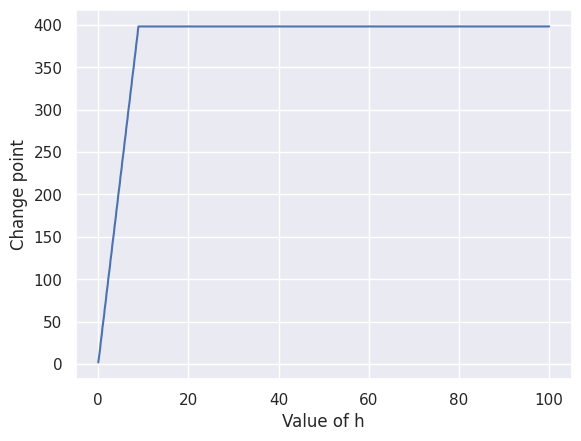

In [61]:
plt.plot(test_visual[1],test_visual[0])
plt.xlabel('Value of h')
plt.ylabel('Change point')
plt.show()